# Setting up the environment

In [1]:
from google.colab import drive
import os
from google.colab import userdata

# Step 1: Mount Google Drive
# Mount Google Drive to access your GitHub repository
drive.mount('/content/drive', force_remount=True)

# Step 2: Navigate to Your GitHub Repository
# Change to your repository's location in Google Drive
repo_path = "/content/drive/MyDrive/colab_repos/Wav2Vec2-vs-HUbert"  # Adjust to your repository path
os.chdir(repo_path)

# Step 3: Set Git User Identity
# Configure Git with your username and email for committing
!git config --global user.name "FilipLarsson12"
!git config --global user.email "hockeyfilip12@gmail.com"

# Step 4: Configure Git Remote
# Use the GitHub Personal Access Token from secrets for authentication
github_token = userdata.get("github_access_token")  # Retrieve the secret
repo_url = f"https://{github_token}@github.com/FilipLarsson12/Wav2Vec2-vs-HUbert.git"

# Set or update the Git remote
!git remote set-url origin {repo_url}

# Step 5: Stage, Commit, and Push Changes
# Add the file(s) to the Git staging area
!git add "Wav2Vec2forER KEX.ipynb"  # Adjust to your notebook's name

# Commit with a meaningful message
!git commit -m "Updated Google Colab notebook"

# Push to GitHub
!git push origin main  # Push to 'main'


Mounted at /content/drive
[main db79b7d] Updated Google Colab notebook
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite Wav2Vec2forER KEX.ipynb (85%)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 650 bytes | 43.00 KiB/s, done.
Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/FilipLarsson12/Wav2Vec2-vs-HUbert.git
   56b4af4..db79b7d  main -> main


In [2]:
%%capture

!pip install git+https://github.com/huggingface/datasets.git
!pip install git+https://github.com/huggingface/transformers.git
!pip install jiwer
!pip install torchaudio
!pip install librosa


In [3]:
%env LC_ALL=C.UTF-8
%env LANG=C.UTF-8
%env TRANSFORMERS_CACHE=/content/cache
%env HF_DATASETS_CACHE=/content/cache
%env CUDA_LAUNCH_BLOCKING=1

env: LC_ALL=C.UTF-8
env: LANG=C.UTF-8
env: TRANSFORMERS_CACHE=/content/cache
env: HF_DATASETS_CACHE=/content/cache
env: CUDA_LAUNCH_BLOCKING=1


In [4]:
# Monitor the training process
!pip install wandb

In [5]:
# # Uncomment this part if you want to setup your wandb project
from google.colab import userdata
import os
wandb_token = userdata.get("WANDB_TOKEN")

%env WANDB_WATCH=all
%env WANDB_LOG_MODEL=1
%env WANDB_PROJECT=Wav2Vec2forER
!wandb login {wandb_token} --relogin  # Use the secret for authentication


env: WANDB_WATCH=all
env: WANDB_LOG_MODEL=1
env: WANDB_PROJECT=Wav2Vec2forER
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Loading in and preparing the RAVDESS dataset

In [6]:
from datasets import load_dataset

# Set the custom cache directory to your new destination
import os

# Re-load the dataset with the new cache
dataset = load_dataset("narad/ravdess")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Using the latest cached version of the module from /root/.cache/huggingface/modules/datasets_modules/datasets/narad--ravdess/5f2ad9e6bf9b595cb9155515e4dceefe3422335dbe0870fd00563e5c6a3632cc (last modified on Sun Apr 21 17:58:24 2024) since it couldn't be found locally at narad/ravdess, or remotely on the Hugging Face Hub.


In [7]:
import numpy as np
import pandas as pd

from pathlib import Path
from tqdm import tqdm

import torchaudio
from sklearn.model_selection import train_test_split

import os
import sys

In [8]:
import torchaudio
import librosa
import IPython.display as ipd
import numpy as np

In [9]:
print(dataset['train'])

Dataset({
    features: ['audio', 'text', 'labels', 'speaker_id', 'speaker_gender'],
    num_rows: 1440
})


Creating label2id and id2label dictionaries to get easier overview of classes and labels.

In [10]:
# Get information about the dataset
print(dataset['train'].features)
label_names = dataset['train'].features['labels'].names
print(label_names)

# Create a dictionary mapping label names to their corresponding IDs
label2id = {name: idx for idx, name in enumerate(label_names)}

# Create a dictionary mapping label IDs to their corresponding label names
id2label = {idx: name for idx, name in enumerate(label_names)}

# Print the dictionaries
print("Label to ID:", label2id)
print("ID to Label:", id2label)

{'audio': Audio(sampling_rate=48000, mono=True, decode=True, id=None), 'text': Value(dtype='string', id=None), 'labels': ClassLabel(names=['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised'], id=None), 'speaker_id': Value(dtype='string', id=None), 'speaker_gender': Value(dtype='string', id=None)}
['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
Label to ID: {'neutral': 0, 'calm': 1, 'happy': 2, 'sad': 3, 'angry': 4, 'fearful': 5, 'disgust': 6, 'surprised': 7}
ID to Label: {0: 'neutral', 1: 'calm', 2: 'happy', 3: 'sad', 4: 'angry', 5: 'fearful', 6: 'disgust', 7: 'surprised'}


In [11]:
df = dataset['train'].to_pandas()

In [12]:
df.head()

,audio,text,labels,speaker_id,speaker_gender
0,"{'bytes': None, 'path': '/content/cache/downlo...",Dogs are sitting by the door,5,16,female
1,"{'bytes': None, 'path': '/content/cache/downlo...",Dogs are sitting by the door,1,16,female
2,"{'bytes': None, 'path': '/content/cache/downlo...",Kids are talking by the door,2,16,female
3,"{'bytes': None, 'path': '/content/cache/downlo...",Dogs are sitting by the door,1,16,female
4,"{'bytes': None, 'path': '/content/cache/downlo...",Dogs are sitting by the door,0,16,female


Adding an emotion column to the Dataframe to make things more clear.

In [13]:
df["emotion"] = df["labels"].map(id2label)

In [14]:
df.head()

,audio,text,labels,speaker_id,speaker_gender,emotion
0,"{'bytes': None, 'path': '/content/cache/downlo...",Dogs are sitting by the door,5,16,female,fearful
1,"{'bytes': None, 'path': '/content/cache/downlo...",Dogs are sitting by the door,1,16,female,calm
2,"{'bytes': None, 'path': '/content/cache/downlo...",Kids are talking by the door,2,16,female,happy
3,"{'bytes': None, 'path': '/content/cache/downlo...",Dogs are sitting by the door,1,16,female,calm
4,"{'bytes': None, 'path': '/content/cache/downlo...",Dogs are sitting by the door,0,16,female,neutral


Listening to a random sample:

In [15]:
idx = np.random.randint(0, len(df))
sample = df.iloc[idx]

path = sample['audio']["path"]
label = sample["emotion"]


print(f"ID Location: {idx}")
print(f"      Label: {label}")
print()

speech, sr = torchaudio.load(path)
print(path)
print(speech[0])
speech = speech[0].numpy().squeeze()
print(speech)
speech = librosa.resample(y=speech, orig_sr=sr, target_sr=16000)  # Corrected usage
ipd.Audio(data=np.asarray(speech), autoplay=False, rate=16000)

ID Location: 1180
      Label: angry

/content/cache/downloads/extracted/90a2946071fd672392e66dcb12cae53c7db0f9869229dc41def316e96a8dc54b/Actor_05/03-01-05-02-02-02-05.wav
tensor([3.0518e-05, 3.0518e-05, 3.0518e-05,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00])
[3.0517578e-05 3.0517578e-05 3.0517578e-05 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00]


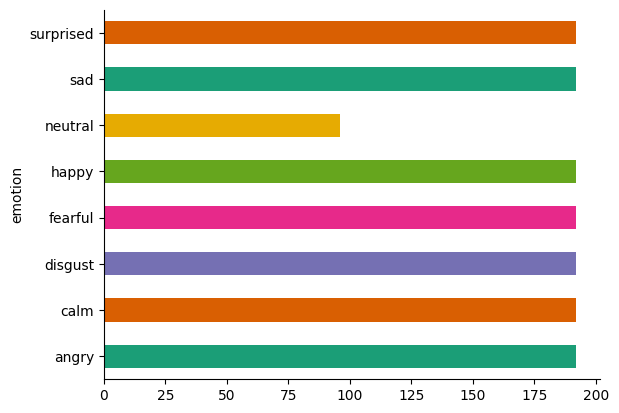

In [16]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('emotion').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [17]:
print("Labels: ", df["emotion"].unique())
print()
df.groupby("emotion").count()['audio']

Labels:  ['fearful' 'calm' 'happy' 'neutral' 'surprised' 'angry' 'sad' 'disgust']



emotion
angry        192
calm         192
disgust      192
fearful      192
happy        192
neutral       96
sad          192
surprised    192
Name: audio, dtype: int64

Restructuring the dataframe a bit for clarity:

In [18]:
df["path"] = df["audio"].apply(lambda audio: audio.get("path", None))


def speech_file_to_array_fn(path):
    speech_array, sampling_rate = torchaudio.load(path)
    resampler = torchaudio.transforms.Resample(sampling_rate, target_sampling_rate)
    speech = resampler(speech_array).squeeze().numpy()
    return speech

target_sampling_rate = 16000

# Creating a new column 'input_values' that contains the speech signal with 16000. hz sampling rate:

df["input_values"] = df["path"].apply(speech_file_to_array_fn)

# Removing the 'audio' column as its redundant
df = df.drop("audio", axis=1)  # axis=1 specifies columns



In [19]:
df.head()

,text,labels,speaker_id,speaker_gender,emotion,path,input_values
0,Dogs are sitting by the door,5,16,female,fearful,/content/cache/downloads/extracted/90a2946071f...,"[-4.1304293e-06, -8.2990355e-06, 1.8151835e-06..."
1,Dogs are sitting by the door,1,16,female,calm,/content/cache/downloads/extracted/90a2946071f...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Kids are talking by the door,2,16,female,happy,/content/cache/downloads/extracted/90a2946071f...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Dogs are sitting by the door,1,16,female,calm,/content/cache/downloads/extracted/90a2946071f...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Dogs are sitting by the door,0,16,female,neutral,/content/cache/downloads/extracted/90a2946071f...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Now we are gonna split the dataset into a train and test split and also save them into content/data as csv files:

In [20]:
import os

save_path = "/content/data"

os.makedirs(save_path, exist_ok=True)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=101, stratify=df["labels"])

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_df.to_csv(f"{save_path}/train.csv", sep="\t", encoding="utf-8", index=False)
test_df.to_csv(f"{save_path}/test.csv", sep="\t", encoding="utf-8", index=False)


print(train_df.shape)
print(test_df.shape)

(1152, 7)
(288, 7)


In [21]:
unique_labels = df["emotion"].unique()
print(unique_labels)
print(f"A classification problem with {len(unique_labels)} emotions.")

['fearful' 'calm' 'happy' 'neutral' 'surprised' 'angry' 'sad' 'disgust']
A classification problem with 8 emotions.


# Loading in the Wav2Vec2 model

In [1]:
from transformers import AutoConfig, Wav2Vec2Processor

In [2]:
model_name_or_path = "facebook/Wav2Vec2-Base-960h"
pooling_mode = "mean"

In [3]:
print(label2id)
print(id2label)

# config
config = AutoConfig.from_pretrained(
    model_name_or_path,
    num_labels=len(unique_labels),
    label2id=label2id,
    id2label=id2label,
    finetuning_task="wav2vec2_clf",
)
setattr(config, 'pooling_mode', pooling_mode)
print(config)

NameError: name 'label2id' is not defined

In [ ]:
processor = Wav2Vec2Processor.from_pretrained(model_name_or_path)
target_sampling_rate = processor.feature_extractor.sampling_rate
print(f"The target sampling rate: {target_sampling_rate}")